In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
# Importing Libraries
import numpy as np
import pandas as pd
#import geopandas as gpd
import os
import seaborn as sns
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from yellowbrick.classifier import ClassificationReport
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Data Importing

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/crime_2010-2017.csv',sep=',') 
df['Total'] = 1
df.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId,Total
0,-79.405228,43.656982,7801,GO-20152165447,2015-12-18T03:58:00.000Z,2015-12-18T03:59:00.000Z,Commercial,1430,100,Assault,2015,December,18,352,Friday,3,2015.0,December,18.0,352.0,Friday,3,Assault,D14,79,University (79),-79.405228,43.656982,7001,1
1,-79.307907,43.778732,7802,GO-20151417245,2015-08-15T21:45:00.000Z,2015-08-17T22:11:00.000Z,Commercial,1430,100,Assault,2015,August,17,229,Monday,22,2015.0,August,15.0,227.0,Saturday,21,Assault,D42,118,Tam O'Shanter-Sullivan (118),-79.307907,43.778732,7002,1
2,-79.225029,43.765942,7803,GO-20151421107,2015-08-16T16:00:00.000Z,2015-08-18T14:40:00.000Z,Apartment,2120,200,B&E,2015,August,18,230,Tuesday,14,2015.0,August,16.0,228.0,Sunday,16,Break and Enter,D43,137,Woburn (137),-79.225029,43.765942,7003,1
3,-79.140823,43.778648,7804,GO-20152167714,2015-11-26T13:00:00.000Z,2015-12-18T13:38:00.000Z,Other,2120,200,B&E,2015,December,18,352,Friday,13,2015.0,November,26.0,330.0,Thursday,13,Break and Enter,D43,133,Centennial Scarborough (133),-79.140823,43.778648,7004,1
4,-79.288361,43.691235,7805,GO-20152169954,2015-12-18T19:50:00.000Z,2015-12-18T19:55:00.000Z,Commercial,1430,100,Assault,2015,December,18,352,Friday,19,2015.0,December,18.0,352.0,Friday,19,Assault,D55,61,Taylor-Massey (61),-79.288361,43.691235,7005,1


### Data Visualisation
---
#### Plotting bargraph for Major Crime Indicators

#### Plotting Line Chart for Total Criminal Cases from 2014 to 2019

occurrenceyear
2014.0    31638
2015.0    32316
2016.0    32809
2017.0    34561
2018.0    36323
2019.0    37674
dtype: int64


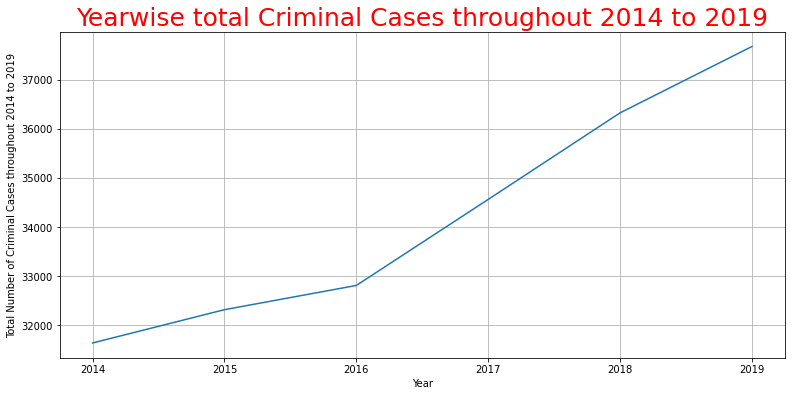

In [7]:
# Creating a Countplot
df2 = df[df['occurrenceyear'] > 2013]
yearwise_total_crime = df2.groupby('occurrenceyear').size()
print(yearwise_total_crime)

plt.figure(figsize=(13,6))
ct = yearwise_total_crime.sort_values(ascending=True)
ax = ct.plot.line()
ax.set_xlabel('Year')
ax.set_ylabel('Total Number of Criminal Cases throughout 2014 to 2019')
ax.set_title('Yearwise total Criminal Cases throughout 2014 to 2019',color = 'red',fontsize=25)
ax.grid(linestyle='-')
plt.show()

#### Plotting Pie chart for crime according to premisetype

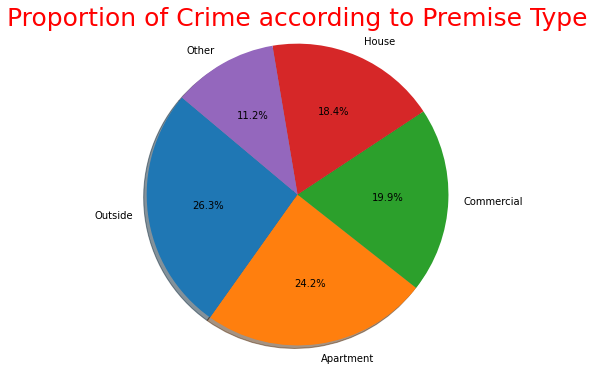

In [8]:
# Proportion of crime according to premisetype
premise_type = df.groupby('premisetype').size()
premise_type.head()
labels = ['Outside','Apartment','Commercial','House','Other']
count = [54253,49996,41081,37927,23178]
explode = (0, 0, 0, 0, 0) 

fig, ax = plt.subplots(figsize = (6,6))
ax.pie(count, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Proportion of Crime according to Premise Type", color='red', fontsize=25)
plt.show()

#### Plotting line graph for crime types by hour of day

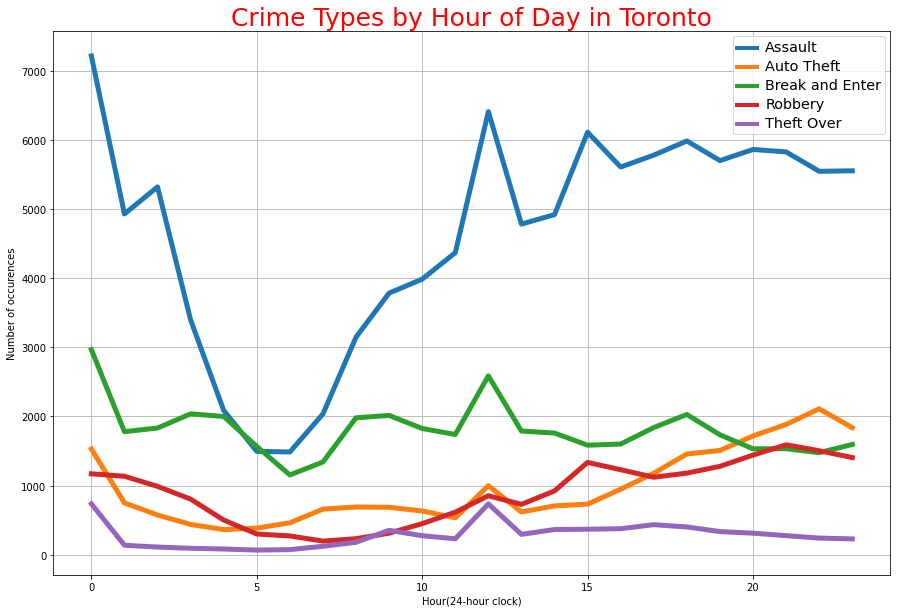

In [11]:
hour_crime_group = df.groupby(['occurrencehour','MCI'],as_index=False).agg({'Total':'sum'})
#print(hour_crime_group)

fig, ax = plt.subplots(figsize=(15,10))
hour_crime_group.groupby('MCI').plot(x="occurrencehour", y="Total", ax=ax,linewidth=5)
ax.set_xlabel('Hour(24-hour clock)')
ax.set_ylabel('Number of occurences')
ax.set_title('Crime Types by Hour of Day in Toronto',color = 'red',fontsize=25)
ax.grid(linestyle='-')
leg = plt.legend([v[0] for v in hour_crime_group.groupby('MCI')['MCI']])
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=4)
plt.setp(leg_texts, fontsize='x-large')
plt.show()

#### Plotting Heatmap for Major Crime indicator by Month

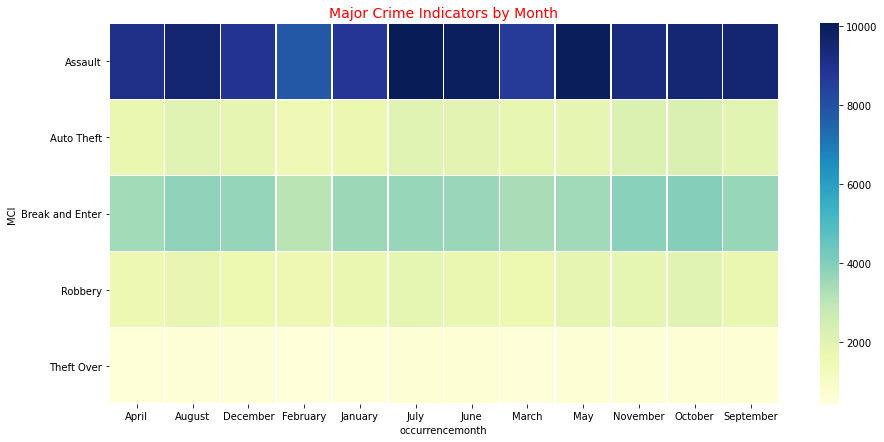

In [13]:
# Plot a heatmap
mci_monthwise = df.groupby(['occurrencemonth','MCI'],as_index=False).agg({'Total':'sum'})

plt.figure(figsize=(15, 7))
crime_count = mci_monthwise.pivot("MCI","occurrencemonth","Total" )

plt.yticks(rotation=1)
ax = sns.heatmap(crime_count,cmap="YlGnBu", linewidths=.5)
plt.title("Major Crime Indicators by Month",color = 'red',fontsize=14)
plt.show()

### Data Preprocessing

In [14]:
# Columns for the models
col_list = ['occurrenceyear',	'occurrencemonth','occurrenceday','occurrencedayofyear','occurrencedayofweek','occurrencehour','MCI',	'Division',	'Hood_ID','premisetype']

# New dataframe from columns
df2 = df[col_list]
df2 = df2[df2['occurrenceyear'] > 2013]

#Factorize dependent variable column:
crime_var = pd.factorize(df2['MCI'])
df2['MCI'] = crime_var[0]
definition_list_MCI = crime_var[1]

#factorize independent variables:
premise_var = pd.factorize(df2['premisetype'])
df2['premisetype'] = premise_var[0]
definition_list_premise = premise_var[1] 

#factorize occurenceyear:
year_var = pd.factorize(df2['occurrenceyear'])
df2['occurrenceyear'] = year_var[0]
definition_list_year = year_var[1] 

#factorize occurencemonth:
month_var = pd.factorize(df2['occurrencemonth'])
df2['occurrencemonth'] = month_var[0]
definition_list_month = month_var[1] 

#factorize occurenceday:
day_var = pd.factorize(df2['occurrenceday'])
df2['occurenceday'] = day_var[0]
definition_list_day = day_var[1] 

#factorize occurencedayofweek:
dayweek_var = pd.factorize(df2['occurrencedayofweek'])
df2['occurrencedayofweek'] = dayweek_var[0]
definition_list_day = dayweek_var[1] 

#factorize division:
division_var = pd.factorize(df2['Division'])
df2['Division'] = division_var[0]
definition_list_division = division_var[1] 

#factorize HOOD_ID:
hood_var = pd.factorize(df2['Hood_ID'])
df2['Hood_ID'] = hood_var[0]
definition_list_hood = hood_var[1] 

#factorize occurencehour:
hour_var = pd.factorize(df2['occurrencehour'])
df2['occurrencehour'] = hour_var[0]
definition_list_hour = hour_var[1] 

#factorize occurencedayofyear:
dayyear_var = pd.factorize(df2['occurrencedayofyear'])
df2['occurrencedayofyear'] = dayyear_var[0]
definition_list_dayyear = dayyear_var[1] 

#### Splitting the dataset into training and tests set

In [15]:
#set X and Y:
X = df2.drop(['MCI'],axis=1).values
y = df2['MCI'].values

#split the data into train and test sets for numeric encoded dataset:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

#need to OneHotEncode all the X variables for input into the classification model:
binary_encoder = OneHotEncoder(sparse=False,categories='auto')
encoded_X = binary_encoder.fit_transform(X)
X_train_OH, X_test_OH, y_train_OH, y_test_OH = train_test_split(encoded_X, y, test_size = 0.25, random_state = 21)

## Crime Predictions
---
### Predicting the type of major crime committed based on time of day, neighbourhood, division, year, month, etc.
#### Classification Analysis
When the true goal of data analysis is to be able to predict which of several non-overlapping groups an observation belongs to, the techniques we use are known as classification techniques.It is a Data analysis task, i.e. the process of finding a model that describes and distinguishes data classes and concepts. Classification is the problem of identifying to which of a set of categories (subpopulations), a new observation belongs to, on the basis of a training set of data containing observations and whose categories membership is known.


---
#### Data Preprocessing

In [39]:
# Numeric Encoded Model
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Accuracy of Random Forest : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred)) 
print(classification_report(y_test,y_pred, target_names=definition_list_MCI)) 

Accuracy of Random Forest :  0.6352691356100602
[[23861  2290   662    65   863]
 [ 5261  5034    67    66   272]
 [ 2991   288  1731    11   339]
 [ 1119   337    46    29   148]
 [ 2853   750   263    31  1954]]
                 precision    recall  f1-score   support

        Assault       0.66      0.86      0.75     27741
Break and Enter       0.58      0.47      0.52     10700
        Robbery       0.63      0.32      0.43      5360
     Theft Over       0.14      0.02      0.03      1679
     Auto Theft       0.55      0.33      0.41      5851

       accuracy                           0.64     51331
      macro avg       0.51      0.40      0.43     51331
   weighted avg       0.61      0.64      0.60     51331



In [40]:
#One Hot Encoded Model
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(X_train_OH, y_train_OH)
y_pred_OH = classifier.predict(X_test_OH)

print("Accuracy of Random Forest with OneHotEncoder : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test_OH, y_pred_OH)) 
print(classification_report(y_test_OH,y_pred_OH, target_names=definition_list_MCI))

Accuracy of Random Forest with OneHotEncoder :  0.6352691356100602
[[24536  1948   499    28   730]
 [ 5223  5157    33    54   233]
 [ 3107   253  1673     6   321]
 [ 1168   319    25    24   143]
 [ 3012   621   176    17  2025]]
                 precision    recall  f1-score   support

        Assault       0.66      0.88      0.76     27741
Break and Enter       0.62      0.48      0.54     10700
        Robbery       0.70      0.31      0.43      5360
     Theft Over       0.19      0.01      0.03      1679
     Auto Theft       0.59      0.35      0.44      5851

       accuracy                           0.65     51331
      macro avg       0.55      0.41      0.44     51331
   weighted avg       0.63      0.65      0.62     51331



In [44]:
Features = ["premisetype","Division","occurrencedayofweek"]

In [45]:
Target = "MCI"
print("predict type: ",Target)

predict type:  MCI


In [46]:
classes = df["MCI"].unique()
classes

array(['Assault', 'Break and Enter', 'Robbery', 'Theft Over',
       'Auto Theft'], dtype=object)

In [47]:
from sklearn.neural_network import MLPClassifier

In [48]:
#Split dataset to Training Set & Test Set
x, y = train_test_split(df2, 
                        test_size = 0.4, 
                        train_size = 0.6, 
                        random_state= 1)

x1 = x[Features]    #Features to train
x2 = x[Target]      #Target Class to train
y1 = y[Features]    #Features to test
y2 = y[Target]      #Target Class to test

print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Feature Set Used    :  ['premisetype', 'Division', 'occurrencedayofweek']
Target Class        :  MCI
Training Set Size   :  (123192, 11)
Test Set Size       :  (82129, 11)


In [49]:
# Neural Network
# Create Model with configuration 
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(500,), 
                         random_state=1,
                         max_iter=1000                         
                        )

# Model Training
nn_model.fit(X=x1,
             y=x2)

# Prediction
result = nn_model.predict(y[Features]) 

In [50]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Neural Network Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== Neural Network Results ==========
Accuracy    :  0.5571479014720744
Recall      :  0.5571479014720744
Precision   :  0.461578424796213
F1 Score    :  0.5571479014720744
Confusion Matrix: 
[[41819  1493     0     0   832]
 [14335  2851     0     0    79]
 [ 8133    66     0     0   533]
 [ 2413   180     0     0    70]
 [ 7420   817     0     0  1088]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


================= Classification Report =================

                 precision    recall  f1-score   support

        Assault       0.56      0.95      0.71     44144
Break and Enter       0.53      0.17      0.25     17265
        Robbery       0.00      0.00      0.00      8732
     Theft Over       0.00      0.00      0.00      2663
     Auto Theft       0.42      0.12      0.18      9325

       accuracy                           0.56     82129
      macro avg       0.30      0.25      0.23     82129
   weighted avg       0.46      0.56      0.45     82129



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


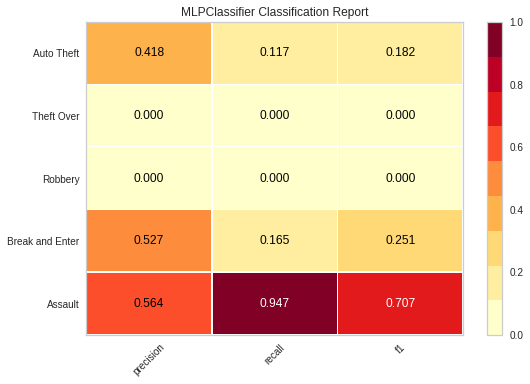

In [51]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = classes
visualizer = ClassificationReport(nn_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof() 